In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
sys.path.append(os.path.abspath('../Scripts'))

In [6]:
from load_data import load_data_from_postgres

In [7]:
# Define your SQL query
query = "SELECT * FROM xdr_data;"  # Replace with your actual table name

# Load data from PostgreSQL
df = load_data_from_postgres(query)

# Display the first few rows of the dataframe
if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")

Successfully loaded the data


In [8]:
from utils import OverviewAnalysis
data = OverviewAnalysis(df)

In [9]:
# Handle missing values and outliers
data.handle_missing_values(df)
data.handle_outliers()

Missing values handled.
Outliers handled.


### Aggregate Data Per Customer (MSISDN):

In [10]:
# Calculate the total TCP Retransmission (DL + UL)
df['Total TCP Retrans. Vol (Bytes)'] = df['TCP DL Retrans. Vol (Bytes)'] + df['TCP UL Retrans. Vol (Bytes)']

# Calculate the average TCP Retransmission Volume
df['Avg TCP Retrans. Vol (Bytes)'] = df['Total TCP Retrans. Vol (Bytes)'] / 2
# Step 1: Handle missing values for numeric columns by replacing with mean
numeric_columns = ['Avg TCP Retrans. Vol (Bytes)', 'Avg RTT DL (ms)', 'Avg RTT UL (ms)', 
                   'Avg Bearer TP DL (kbps)', 'Avg Bearer TP UL (kbps)']

df[numeric_columns] = df[numeric_columns].apply(lambda x: x.fillna(x.mean()))

# Handle missing values for the 'Handset Type' column by replacing with mode
df['Handset Type'] = df['Handset Type'].fillna(df['Handset Type'].mode()[0])

# Step 2: Handle outliers using IQR method (for numeric columns)
Q1 = df[numeric_columns].quantile(0.25)
Q3 = df[numeric_columns].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds for each numeric column
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Replace outliers with mean value of the corresponding column
for col in numeric_columns:
    df[col] = np.where(df[col] < lower_bound[col], df[col].mean(), df[col])
    df[col] = np.where(df[col] > upper_bound[col], df[col].mean(), df[col])

# Step 3: Aggregate per customer (MSISDN)
customer_aggregates = df.groupby('MSISDN/Number').agg(
    avg_tcp_retransmission=('Avg TCP Retrans. Vol (Bytes)', 'mean'),
    avg_rtt_dl=('Avg RTT DL (ms)', 'mean'),
    avg_rtt_ul=('Avg RTT UL (ms)', 'mean'),
    avg_throughput_dl=('Avg Bearer TP DL (kbps)', 'mean'),
    avg_throughput_ul=('Avg Bearer TP UL (kbps)', 'mean'),
    most_common_handset=('Handset Type', lambda x: x.mode()[0])
).reset_index()

# Combine RTT DL and RTT UL into a single average RTT
customer_aggregates['avg_rtt'] = (customer_aggregates['avg_rtt_dl'] + customer_aggregates['avg_rtt_ul']) / 2
customer_aggregates['avg_throughput'] = (customer_aggregates['avg_throughput_dl'] + customer_aggregates['avg_throughput_ul']) / 2

# Select relevant columns
customer_aggregates = customer_aggregates[['MSISDN/Number', 'avg_tcp_retransmission', 'avg_rtt', 'avg_throughput', 'most_common_handset']]

# Step 4: Display the aggregated data per customer
print(customer_aggregates.head(10))  # Display the top 10 customers


   MSISDN/Number  avg_tcp_retransmission    avg_rtt  avg_throughput  \
0   3.360100e+10            1.078479e+07  23.000000       38.000000   
1   3.360100e+10            1.078479e+07  15.500000       49.500000   
2   3.360100e+10            1.078479e+07  63.729294       48.500000   
3   3.360101e+10            3.803623e+05  42.000000      124.000000   
4   3.360101e+10            7.735101e+06  29.750000    10551.357162   
5   3.360101e+10            5.582998e+06  37.864647     1977.000000   
6   3.360101e+10            5.419951e+06  13.250000    10628.250000   
7   3.360101e+10            3.799683e+05  26.000000      623.500000   
8   3.360101e+10            1.078479e+07  63.729294       47.250000   
9   3.360102e+10            1.040560e+07  31.000000       73.000000   

                                most_common_handset  
0                    Huawei P20 Lite Huawei Nova 3E  
1                            Apple iPhone 7 (A1778)  
2                                         undefined  
3 

### Compute and List the Top 10, Bottom 10, and Most Frequent Values:

In [11]:
# Top 10, Bottom 10, and Most Frequent TCP, RTT, Throughput values
tcp_col = 'Avg TCP Retrans. Vol (Bytes)'
rtt_dl_col = 'Avg RTT DL (ms)'
rtt_ul_col = 'Avg RTT UL (ms)'
throughput_dl_col = 'Avg Bearer TP DL (kbps)'
throughput_ul_col = 'Avg Bearer TP UL (kbps)'

# TCP Retransmission
top_10_tcp = df[tcp_col].nlargest(10)
bottom_10_tcp = df[tcp_col].nsmallest(10)
most_frequent_tcp = df[tcp_col].value_counts().head(10)

# RTT
top_10_rtt = (df[rtt_dl_col] + df[rtt_ul_col]).nlargest(10)
bottom_10_rtt = (df[rtt_dl_col] + df[rtt_ul_col]).nsmallest(10)
most_frequent_rtt = (df[rtt_dl_col] + df[rtt_ul_col]).value_counts().head(10)

# Throughput
top_10_throughput = (df[throughput_dl_col] + df[throughput_ul_col]).nlargest(10)
bottom_10_throughput = (df[throughput_dl_col] + df[throughput_ul_col]).nsmallest(10)
most_frequent_throughput = (df[throughput_dl_col] + df[throughput_ul_col]).value_counts().head(10)

# Display Results
print("Top 10 TCP values:", top_10_tcp)
print("Bottom 10 TCP values:", bottom_10_tcp)
print("Most Frequent TCP values:", most_frequent_tcp)

print("Top 10 RTT values:", top_10_rtt)
print("Bottom 10 RTT values:", bottom_10_rtt)
print("Most Frequent RTT values:", most_frequent_rtt)

print("Top 10 Throughput values:", top_10_throughput)
print("Bottom 10 Throughput values:", bottom_10_throughput)
print("Most Frequent Throughput values:", most_frequent_throughput)


Top 10 TCP values: 3704      25842612.5
138739    25841951.5
41883     25837941.0
145801    25824248.5
78753     25805777.5
58917     25798489.0
119306    25788826.5
117801    25785832.0
140790    25760853.5
139798    25752110.0
Name: Avg TCP Retrans. Vol (Bytes), dtype: float64
Bottom 10 TCP values: 143594    43.0
111106    48.5
18432     53.0
13157     54.0
97069     56.5
8816      64.0
99958     64.5
83230     67.0
95965     67.0
12866     71.5
Name: Avg TCP Retrans. Vol (Bytes), dtype: float64
Most Frequent TCP values: Avg TCP Retrans. Vol (Bytes)
1.078479e+07    87846
1.040560e+07      650
3.804943e+05      249
1.040562e+07      248
3.798483e+05      136
1.040562e+07      132
3.798753e+05      132
3.811593e+05      121
3.804883e+05      106
1.040629e+07       99
Name: count, dtype: int64
Top 10 RTT values: 134503    260.0
141235    259.0
28450     258.0
68302     258.0
117970    258.0
769       256.0
36870     255.0
60437     255.0
65749     255.0
66078     255.0
dtype: float64
Bo

### Distribution of Average Throughput per Handset Type

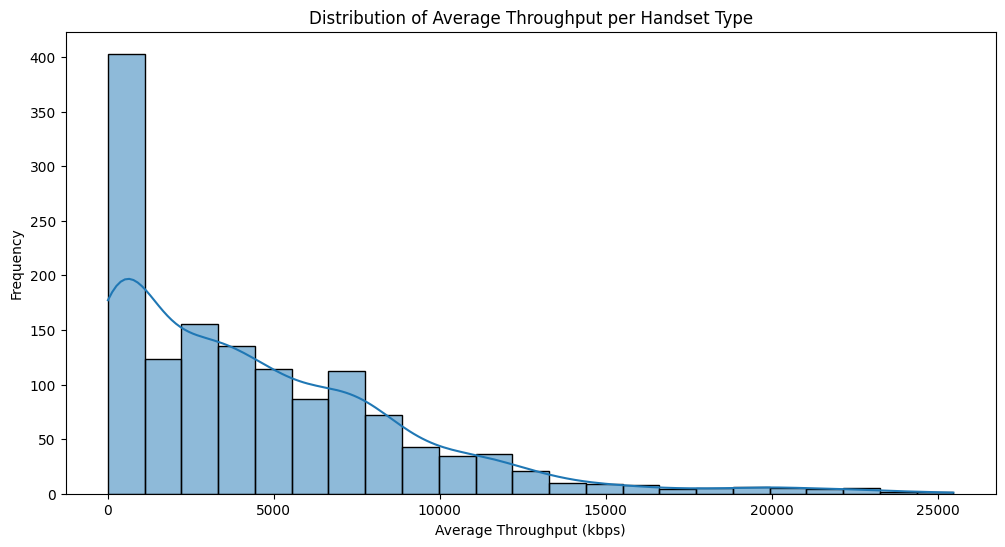

Handset Type
A-Link Telecom I. Cubot A5           11755.000000
A-Link Telecom I. Cubot Note Plus     3349.500000
A-Link Telecom I. Cubot Note S        4468.500000
A-Link Telecom I. Cubot Nova          6925.022963
A-Link Telecom I. Cubot Power         6821.022963
A-Link Telecom I. Cubot R9            2019.500000
A-Link Telecom I. Cubot X18 Plus      6279.500000
Acer Liquid M220                        17.000000
Acer Liquid Z220                       276.000000
Acer Liquid Z530                       167.000000
Name: avg_throughput, dtype: float64


In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute average throughput per handset type
df['avg_throughput'] = (df[throughput_dl_col] + df[throughput_ul_col]) / 2
throughput_by_handset = df.groupby('Handset Type')['avg_throughput'].mean()

# Plot the distribution of average throughput per handset type
plt.figure(figsize=(12, 6))
sns.histplot(throughput_by_handset, kde=True)
plt.title('Distribution of Average Throughput per Handset Type')
plt.xlabel('Average Throughput (kbps)')
plt.ylabel('Frequency')
plt.show()

# Display throughput by handset type
print(throughput_by_handset.head(10))

### Average TCP Retransmission per Handset Type

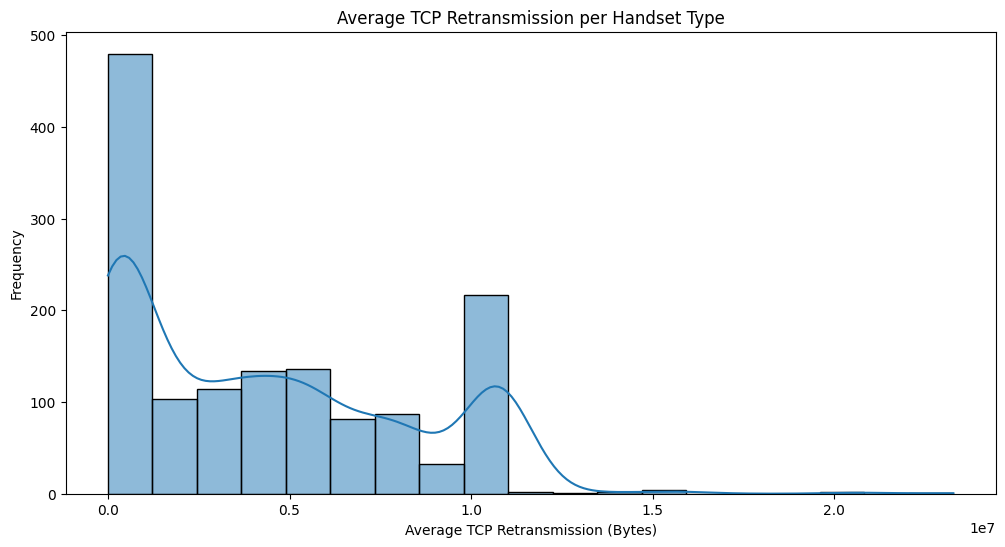

Handset Type
A-Link Telecom I. Cubot A5           1.078479e+07
A-Link Telecom I. Cubot Note Plus    3.081065e+05
A-Link Telecom I. Cubot Note S       2.070587e+07
A-Link Telecom I. Cubot Nova         6.858500e+04
A-Link Telecom I. Cubot Power        4.020500e+03
A-Link Telecom I. Cubot R9           1.549950e+04
A-Link Telecom I. Cubot X18 Plus     8.629524e+05
Acer Liquid M220                     1.078479e+07
Acer Liquid Z220                     8.719350e+04
Acer Liquid Z530                     4.490653e+05
Name: Avg TCP Retrans. Vol (Bytes), dtype: float64


In [13]:
# Compute average TCP retransmission per handset type
tcp_by_handset = df.groupby('Handset Type')[tcp_col].mean()

# Plot the average TCP retransmission per handset type
plt.figure(figsize=(12, 6))
sns.histplot(tcp_by_handset, kde=True)
plt.title('Average TCP Retransmission per Handset Type')
plt.xlabel('Average TCP Retransmission (Bytes)')
plt.ylabel('Frequency')
plt.show()

# Display TCP retransmission by handset type
print(tcp_by_handset.head(10))